In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

nback_pp_t = torch.from_numpy(nback_p).float().cuda()
emoid_pp_t = torch.from_numpy(emoid_p).float().cuda()

print(emoid_pp_t.shape)

torch.Size([620, 264, 264])


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [582]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')

Norm complete


In [583]:
print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [563]:
# Mask Rois

def allowRois(p, rois, conn=False):
    idcs = torch.triu_indices(264,264,offset=1)
    pp = torch.zeros(p.shape[0],264,264).float().cuda()
    pp2 = pp.detach().clone()
    pp[:,idcs[0],idcs[1]] = p.detach()
    for roi in rois:
        if not conn:
            pp2[:,roi,:] = pp[:,roi,:]
            pp2[:,:,roi] = pp[:,:,roi]
        else:
            pp2[:,roi[0],roi[1]] = pp[:,roi[0],roi[1]]
            pp2[:,roi[1],roi[0]] = pp[:,roi[1],roi[0]]
    pp2 = pp2 + pp2.permute(0,2,1)
    return pp2[:,idcs[0],idcs[1]]
    
nback_p_t = allowRois(nback_p_t,[(3, 242), (3, 112), (27, 136), (46, 147), (120, 238), (90, 102), (3, 108), (22, 160), (118, 120), (3, 47), (22, 179), (31, 43), (219, 249), (3, 149), (252, 260), (95, 102), (33, 171), (3, 144), (217, 249), (85, 102), (3, 29), (3, 40), (17, 178), (3, 19), (3, 262), (18, 253), (34, 237), (0, 14), (3, 234), (33, 172), (27, 256), (3, 185), (187, 194), (24, 44), (160, 259), (3, 163), (179, 259), (22, 240), (3, 50), (22, 234), (49, 64), (21, 251), (81, 91), (3, 222), (161, 261), (83, 113), (22, 136), (1, 167), (3, 257), (27, 179), (3, 200), (18, 239), (33, 179), (11, 132), (120, 136), (1, 21), (33, 164), (3, 101), (3, 182), (0, 113)],conn=True)
emoid_p_t = allowRois(emoid_p_t,[(140, 249), (3, 227), (67, 205), (30, 147), (53, 169), (46, 163), (252, 254), (120, 249), (150, 260), (20, 146), (31, 44), (232, 243), (79, 249), (151, 263), (7, 147), (121, 248), (9, 213), (161, 190), (143, 263), (147, 260), (143, 257), (48, 251), (147, 249), (243, 257), (193, 249), (95, 103), (31, 237), (107, 248), (160, 255), (10, 102), (195, 249), (151, 249), (190, 224), (73, 249), (37, 237), (3, 144), (155, 248), (151, 257), (25, 153), (173, 244), (120, 126), (3, 252), (182, 249), (206, 249), (9, 214), (3, 201), (177, 249), (249, 259), (107, 193), (145, 224), (180, 249), (3, 141), (136, 191), (8, 101), (29, 234), (9, 217), (33, 162), (27, 237), (40, 155), (33, 239)],conn=True)
    
print('Complete')

Complete


In [7]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [8]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [8]:
ageG_t = torch.zeros(age_t.numel(), 3).float().cuda()
borders = 12*np.array([8,14,18,24])

for j in range(age_t.numel()):
    for i in range(3):
        if age_t[j] >= borders[i] and age_t[j] < borders[i+1]:
            ageG_t[j,i] = 1
            break

print('Complete')

Complete


In [104]:
import torch

import torch.nn.functional as F
import torch.nn


class Connectome_Filter_Block(torch.nn.Module):
    
    '''Connectome Filter Block'''

    def __init__(self, n_filt, planes, input_ex, bias=False):
       
        super(Connectome_Filter_Block, self).__init__() #initialize
       
        self.d = input_ex.size(3) 
        self.in_planes = input_ex.size(1)
        
        self.cnn1 = torch.nn.Conv2d(n_filt,planes,(1,self.d),bias=bias).float().cuda() #row 
        self.cnn2 = torch.nn.Conv2d(n_filt,planes,(self.d,1),bias=bias).float().cuda() #column

        
    def forward(self, x, l, g_flag):
        
        '''
        Input : 
            x -> rs-fMRI connectome
            l -> DTI Laplacian
            g_flag -> graph filtering on
        '''
        
        if g_flag: #graph pre-filtering if True
            x = torch.matmul(l,x) 
        
        r = self.cnn1(x) #row filtering
        c = self.cnn2(x) #column filterning
        
        nd = list(r.shape)
        nd[3] = self.d
        a = r.expand(*nd) + c.expand(*nd)
        
        return a
    
class M_GCN(torch.nn.Module):
    
    def __init__(self, input_ex, num_classes):
        super(M_GCN, self).__init__()
        
        self.in_planes = input_ex.size(1)
        self.d = input_ex.size(3)
        
        self.cf_1 = Connectome_Filter_Block(1,8,input_ex,bias=True)      
        self.ef_1 = torch.nn.Conv2d(8,1,(1,self.d)).float().cuda()
        self.nf_1 = torch.nn.Conv2d(1,32,(self.d,1)).float().cuda()
        
        #ANN for regression
        self.dense1 = torch.nn.Linear(32,40).float().cuda()
        self.dense2 = torch.nn.Linear(40,num_classes).float().cuda()
        
    def forward(self, x, l, g_f):

        out = self.cf_1(x, l, g_f)

        if g_f:  # graph filtering     
            out = torch.matmul(l,out) # graph filtering
            
        out = self.ef_1(out)
       
        if g_f:  # graph filtering     
            out = torch.matmul(l,out)
       
        out = self.nf_1(out)
     
        #regression
        out = out.reshape(out.shape[0], -1)    
        out = F.relu(self.dense1(out))
        out = self.dense2(out)
        
        return out
    
def init_weights(m):
    
    if type(m) == torch.nn.Linear:
            
            torch.nn.init.xavier_normal(m.weight, gain=torch.nn.init.calculate_gain('relu'))
            m.bias.data.fill_(1e-02)
            
class Guys(torch.nn.Module):
    def __init__(self, input_ex, num_classes, nTgt, dp=0.5):
        super(Guys, self).__init__()
        self.mgcn = []
        for i in range(nTgt):
            self.mgcn.append(M_GCN(input_ex, num_classes))
        self.mgcn = nn.ModuleList(self.mgcn)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            res.append(self.mgcn[i](x[:,i:i+1,:,:], None, False).squeeze())
        return res
            
print('Complete')

Complete


In [30]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv
import time

def arith(n):
    return int(n*(n+1)/2)

class GCN(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(GCN, self).__init__()
        self.gcn = []
        for i in range(2*nTgt):
            self.gcn.append(DenseGCNConv(arith(263),40).float().cuda())
            self.gcn.append(DenseGCNConv(40,1).float().cuda())
        self.gcn = nn.ModuleList(self.gcn)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
            y = self.gcn[2*i+1](y,e).squeeze()
            res.append(y)
        return res
    
class MLP(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(MLP, self).__init__()
        self.lin = []
        for i in range(2*nTgt):
            self.lin.append(nn.Linear(arith(263),40).float().cuda())
            self.lin.append(nn.Linear(40,1).float().cuda())
        self.lin = nn.ModuleList(self.lin)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.lin[2*i](x[:,i,:])).squeeze()
            y = self.lin[2*i+1](y).squeeze()
            res.append(y)
        return res
    
def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res = model(X)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
    
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 10000
pPeriod = 500
thresh = 100

para = [nback_p_t, emoid_p_t]
# para = [nback_pp_t, emoid_pp_t]
rmse = []
finalRes = 10*[None]

X = torch.stack(para, dim=1)

t = time.time()
for i in range(10):
    gcn0 = GCN(2, 0.5) #Guys(X, 2, 2, 0.5)
    params = list(gcn0.parameters())
    optim = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-4) # 2e-4

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    Xt.requires_grad_(True)
    
    trainLoss = []
    validLoss = []
    
    val = wrt_t
    
    for epoch in range(nEpochs):
        Xt.grad = None
        optim.zero_grad()
        res = gcn0(Xt)
        avg = torch.mean(torch.stack(res), dim=0)
        loss0 = 0
        for r in res + [avg]:
            loss0 += mseLoss(r, val[trainIdcs])/(len(res)+1)
        loss = torch.stack([loss0])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss0))}')
            lossV = validate(gcn0, Xv, val[validIdcs], np.arange(496,len(validIdcs)))
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(gcn0.state_dict(), '../../Work/LatentSim/gcn.pyt')
                finalRes[i] = Xt.grad.detach()
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    gcn0.load_state_dict(torch.load('../../Work/LatentSim/gcn.pyt'))
    loss0 = validate(gcn0, X, val, testIdcs)

    rmse.append((float(loss0)))
        
    print(i, end=' ')
    print(rmse[-1])
    
print(time.time()-t)

epoch 0 loss=10868.58984375
New best validation epoch 0 loss=97.14173889160156
epoch 500 loss=336.1521911621094
New best validation epoch 500 loss=13.652325630187988
epoch 1000 loss=293.4545593261719
New best validation epoch 1000 loss=12.65775203704834
epoch 1500 loss=257.9698486328125
New best validation epoch 1500 loss=11.953559875488281
epoch 2000 loss=234.5464630126953
New best validation epoch 2000 loss=11.684874534606934
epoch 2500 loss=217.88638305664062
New best validation epoch 2500 loss=11.626646995544434
epoch 3000 loss=201.0720977783203
New best validation epoch 3000 loss=11.592387199401855
epoch 3500 loss=183.37376403808594
New best validation epoch 3500 loss=11.530441284179688
epoch 4000 loss=159.99574279785156
New best validation epoch 4000 loss=11.428109169006348
epoch 4500 loss=133.97317504882812
New best validation epoch 4500 loss=11.388932228088379
epoch 5000 loss=108.87507629394531
New best validation epoch 5000 loss=11.303833961486816
epoch 5087 loss=99.2815246582

epoch 2000 loss=226.06182861328125
New best validation epoch 2000 loss=12.027360916137695
epoch 2500 loss=206.45448303222656
New best validation epoch 2500 loss=11.834993362426758
epoch 3000 loss=187.60565185546875
New best validation epoch 3000 loss=11.597806930541992
epoch 3500 loss=167.755859375
New best validation epoch 3500 loss=11.471619606018066
epoch 4000 loss=143.039794921875
New best validation epoch 4000 loss=11.150679588317871
epoch 4500 loss=119.97484588623047
New best validation epoch 4500 loss=11.056631088256836
epoch 4896 loss=98.67315673828125
New best validation epoch 4896 loss=10.900938987731934
Early stopping
Finished training
8 15.087409973144531
epoch 0 loss=10949.5625
New best validation epoch 0 loss=97.96005249023438
epoch 500 loss=323.9305419921875
New best validation epoch 500 loss=14.019867897033691
epoch 1000 loss=280.86676025390625
New best validation epoch 1000 loss=13.057392120361328
epoch 1500 loss=245.14892578125
New best validation epoch 1500 loss=12.3

In [31]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

12.473339080810547
13.700685501098633
11.763619422912598
14.939789772033691
13.983660697937012
14.245841979980469
16.247623443603516
15.196117401123047
15.087409973144531
15.845582008361816
---
14.348366928100585


In [32]:
import matplotlib.pyplot as plt

def heatmap(cuda):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cuda.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

sn = [torch.mean(t[:,0,:]**2, dim=0) for t in finalRes]
se = [torch.mean(t[:,1,:]**2, dim=0) for t in finalRes]

with open('../../Work/LatentSim/Gcn/WratSaliency.pkl', 'wb') as f:
    pickle.dump([t.detach().cpu().numpy() for t in finalRes], f)
    
print('Complete')

Complete


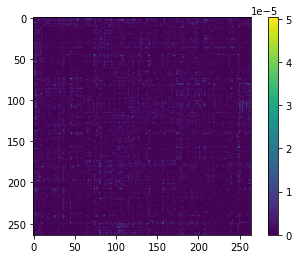

In [34]:
plt.imshow(heatmap(sn[0]))
plt.colorbar()
plt.show()

In [26]:
idcs = np.triu_indices(264,1)
print(idcs[0][34569])
print(idcs[1][34569])

246
253


In [27]:
print(heatmap(sn[1])[246,253])

1.0305923475728562e-10


In [584]:
allVar = [age_t] #, gen_t[:,0], wrt_t]
mats = []

for var in allVar:
    idcs = torch.argsort(var)
#     ref = var[idcs[600]]*torch.ones(620,1).float().cuda()
#     ref = var[idcs].unsqueeze(1)-ref
    mat = torch.cdist(var[idcs].unsqueeze(1), var[idcs].unsqueeze(1))
    mat = torch.max(mat)/2 - mat
    mat = mat# - torch.abs(ref) - torch.abs(ref.T)
    mats.append(mat.detach())
    
print('Complete')

Complete


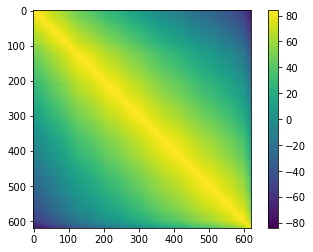

In [585]:
import matplotlib.pyplot as plt

plt.imshow(mats[0].detach().cpu().numpy())
plt.colorbar()
plt.show()

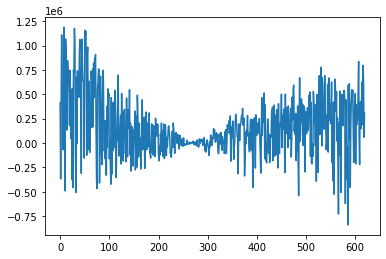

In [602]:
test = Y[:,cidcs[-60:]]
corrSim = torch.einsum('ab,db->ad', test, test)
corrSim = corrSim*mats[0]
corrSim = torch.sum(corrSim, dim=1)

plt.plot(corrSim.detach().cpu().numpy())
plt.show()

In [605]:
idcs = torch.argsort(age_t)
Y = nback_p_t[idcs]

parts = []

for j in range(0,40000,step):
    if j >= Y.shape[1]:
        break
    part = Y[:,j:j+step]
    corrSim = torch.einsum('ab,db->adb', part, part)
    corrByR = torch.einsum('adb,ad->db', corrSim, mats[0])
    parts.append(corrByR.detach().cpu().numpy())

parts = np.concatenate(parts, axis=1)

In [613]:
top5 = np.argsort(parts, axis=1)[:,-5:]

print('Complete')

Complete


In [616]:
top5[2]

array([24512,  8978,  6697,  6705,  6663])

In [587]:
cidcs = np.argsort(parts)
print(parts[cidcs[-60:]]/620/620)
print(cidcs[-60:])

mx, my = np.triu_indices(264,1)
lst = []
for idx in cidcs[-60:]:
    lst.append((mx[idx], my[idx]))
    
print(lst)

ht = np.zeros((264,264))
ht[mx,my] = parts
ht = ht + ht.T

muByRoi = np.mean(ht, axis=0)
print(np.sort(muByRoi)[:20]/620/620)
print(np.argsort(muByRoi)[:20])

[3.9841695 3.9902055 3.9991994 4.0250235 4.0507326 4.0554857 4.062986
 4.063296  4.073055  4.078812  4.0826454 4.082808  4.106192  4.1125317
 4.118296  4.124553  4.1422305 4.155344  4.157916  4.168986  4.204568
 4.216068  4.219317  4.2311425 4.2423015 4.251517  4.251852  4.2536564
 4.2664385 4.2856584 4.30494   4.3094044 4.3130803 4.3162103 4.3271627
 4.347426  4.351941  4.354325  4.3615346 4.3884754 4.401637  4.417307
 4.440042  4.4468226 4.44848   4.4665456 4.5045156 4.5072913 4.5173483
 4.5473623 4.5620446 4.6079936 4.6182303 4.6283126 4.628751  4.6408854
 4.7009587 4.728787  5.094271  5.4265847]
[33300 33897 22879 13563 22414 33197 33141 33193 10263 32776 12946  7149
 19022 33819 23192 33085  8978  4039 12942 33341 18747 23053  8977 33939
 10370 25086 22120  7056 15376 33815 33303 22571 12772  3877 24847  6662
 10371 19041 18750 13975 19135 26035 12075 22570 18731 24947 33977 18729
 16532 12627 24476 12315 12949  4025 33138 33980 26032 33196 10372 33816]
[(210, 226), (223, 225), (1

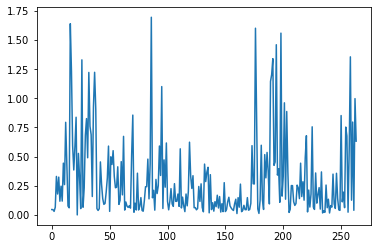

In [511]:
plt.plot(ht[22,:]/620/620)
plt.show()

In [572]:
import torch.nn as nn
import torch.nn.functional as F
import time

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, dp=0.5, dp2=0.1, method='same'):
        super(LatSim, self).__init__()
        self.nTgts = nTgts
        self.method = method
        self.masks = []
        if method == 'same':
            nMasks = nTgts
        elif method == 'diff':
            nMasks = 2*nTgts
        elif method == 'univ':
            nMasks = nTgts+1
        for i in range(nMasks):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(arith(263),2).float().cuda()
            ))
        self.masks = nn.ParameterList(self.masks)
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
        self.ln = nn.LayerNorm((nTgts, nback_p_t.shape[1])).cuda()
    
    def getLatentsAndEdges(self, x, i):
        if self.method == 'univ':
            y = torch.einsum('ac,ce->ae', x, self.masks[0])
            z = torch.einsum('ac,ce->ae', x, self.masks[i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'diff':
            y = torch.einsum('ac,ce->ae', x, self.masks[2*i])
            z = torch.einsum('ac,ce->ae', x, self.masks[2*i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'same':
            y = torch.einsum('ac,ce->ae', x, self.masks[i])
            e = y@y.T+1e-10
            return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.nTgts):
            nClass = y.shape[1] if y.dim() == 2 else 1
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
        
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 5000
pPeriod = 400
thresh = 500

para = [nback_p_t, emoid_p_t]
rmse = []
simMap = []
mat = mats[0]

X = torch.stack(para, dim=1)

t = time.time()
for i in range(10):
    sim = LatSim(len(para), 0, 0, 'same')
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) # 1e-4 age, gender; 1e-5 wrat

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    vIdcs1 = np.arange(496,len(validIdcs))
    vIdcs2 = validIdcs[496:]
    vIdcs3 = np.concatenate([testIdcs, vIdcs2])

    var = age_t
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _ = sim(Xt, var[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss = mseLoss(avg, var[trainIdcs])
        for r in res:
            loss += mseLoss(r, var[trainIdcs])
        loss = torch.stack([loss/(len(res)+1)])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss))}')
            lossV = validate(sim, Xv, var[validIdcs], vIdcs1)
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss = validate(sim, X, var, testIdcs)

    rmse.append((float(loss)))
        
    print(i, end=' ')
    print(rmse[-1])
    
    continue
    
    Y0 = torch.einsum('ab,bc->abc', nback_p_t, sim.masks[0])
    Y1 = torch.einsum('ab,bc->abc', emoid_p_t, sim.masks[1])

    print(Y0.shape)
    print(Y1.shape)

    idcs = torch.argsort(var) if var is age_t or var is wrt_t else torch.argsort(var[:,0])
    Y0sort = Y0[idcs,:,:]
    Y1sort = Y1[idcs,:,:]

    simMapPart = []
    step = 100

    for Y in [Y0sort, Y1sort]:
        parts = []
        for j in range(0,40000,step):
            if j >= Y.shape[1]:
                break
            part = Y[:,j:j+step,:]
            subConnSim = torch.einsum('abc,dbc->adb', part, part)
            subConnR = torch.einsum('adb,ad->b', subConnSim, mat)
            parts.append(subConnR.detach().cpu().numpy())

        parts = np.concatenate(parts)
        simMapPart.append(parts)

    simMap.append(np.stack(simMapPart))
    print('Complete')
    
print(time.time()-t)

epoch 0 loss=1514.715576171875
New best validation epoch 0 loss=44.58447265625
epoch 400 loss=1461.1259765625
New best validation epoch 400 loss=43.534915924072266
epoch 800 loss=1369.856201171875
epoch 1200 loss=1333.8524169921875
epoch 1600 loss=1315.3851318359375
New best validation epoch 1600 loss=43.48381423950195
epoch 2000 loss=1303.4873046875
New best validation epoch 2000 loss=43.22016143798828
epoch 2400 loss=1294.0941162109375
epoch 2800 loss=1284.6024169921875
epoch 3200 loss=1268.6795654296875
epoch 3600 loss=1115.404296875
epoch 4000 loss=969.2890625
epoch 4400 loss=895.7101440429688
epoch 4800 loss=845.8876953125
epoch 4999 loss=827.3637084960938
Finished training
0 38.296871185302734
epoch 0 loss=1470.595703125
New best validation epoch 0 loss=44.033302307128906
epoch 400 loss=1395.7587890625
New best validation epoch 400 loss=41.48173141479492
epoch 800 loss=1343.6055908203125
New best validation epoch 800 loss=41.02500915527344
epoch 1200 loss=1306.93994140625
New bes

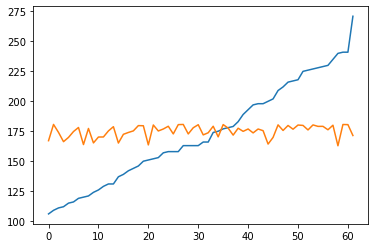

In [570]:
import matplotlib.pyplot as plt

res, _ = sim(X, var, testIdcs)
avg = torch.mean(torch.stack(res), dim=0)

idcs = torch.argsort(var[testIdcs])
avg = avg[testIdcs][idcs]

plt.plot(var[testIdcs][idcs].detach().cpu().numpy())
plt.plot(avg.detach().cpu().numpy())
plt.show()

In [573]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

38.296871185302734
43.029541015625
37.587646484375
38.932254791259766
41.70351028442383
40.733707427978516
41.604732513427734
41.352108001708984
37.09902572631836
40.215370178222656
---
40.05547676086426


In [242]:
simMap = np.stack(simMap)
mu = np.min(simMap[:,0,:], axis=(0))
idcs = np.argsort(mu)

# print(mu[idcs[:80]])

mx, my = np.triu_indices(264,1)
lst = []
for idx in idcs[-2000:]:
#     lst.append((mx[idx],my[idx]))
    lst.append(mx[idx])
    lst.append(my[idx])
    
arr = np.array(lst)
counts, bins = np.histogram(arr, np.unique(arr))

print(np.sort(counts)[-10:])
print(counts[22])
    
# print(lst)

[30 31 31 31 33 34 37 41 48 54]
4


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


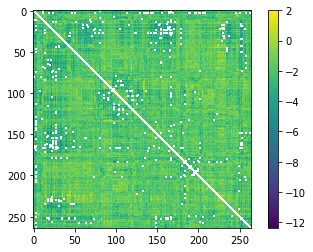

In [220]:
ht = np.zeros((264,264))
ht[mx,my] = mu
ht = ht + ht.T

plt.imshow(np.log(ht))
plt.colorbar()
plt.show()

In [221]:
muByRoi = np.mean(ht, axis=0)
print(np.sort(muByRoi)[-20:])
print(np.argsort(muByRoi)[-20:])

[0.36085305 0.36764215 0.37124087 0.37496123 0.37505341 0.37761008
 0.38001987 0.38090609 0.38095091 0.38179625 0.38307439 0.38996166
 0.40950839 0.41601412 0.41739442 0.44164863 0.44368115 0.45981305
 0.48949513 0.67051393]
[ 16 216 119 225  38 223 230 247  45  90 157 185 224  82 229 134  92 226
  86  94]


In [13]:
def heatmap(cuda):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cuda.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

def heatmaps(cuda):
    ht = []
    for i in range(cuda.shape[0]):
        ht.append(heatmap(cuda[i]))
    return np.stack(ht)

print('Complete')

Complete


In [34]:
import torch.autograd

gcn0.eval()

X.requires_grad = True
res = gcn0(X, age_t)
loss = mseLoss(res[0], age_t)
loss.backward()

ht = heatmaps(X.grad[:,0,:])
print(ht.shape)

X.grad = None

NameError: name 'gcn0' is not defined

In [178]:
mod = 1

with torch.no_grad():
    st0 = X[:,mod,:]*sim.masks[mod][:,0].unsqueeze(0)
    st1 = X[:,mod,:]*sim.masks[mod][:,1].unsqueeze(0)
    
st0 = heatmaps(st0)
st1 = heatmaps(st1)
print(st0.shape)
print(st1.shape)

(620, 264, 264)
(620, 264, 264)


In [187]:
def gradGroup(ht, y, low, high):
    hts = []
    for i in range(len(y)):
        if y[i] >= low and y[i] < high:
            hts.append(ht[i])
    hts = np.stack(hts)
    return hts
    
stYoung = gradGroup(st0, age, 0, 120)
stOld = gradGroup(st0, age, 20*12, 100*12)

print(stYoung.shape)
print(stOld.shape)

(47, 264, 264)
(35, 264, 264)


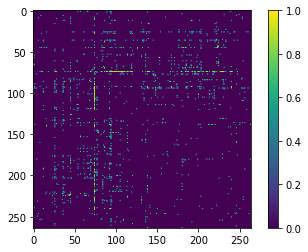

In [188]:
import matplotlib.pyplot as plt

def highlight(m, pct=0.05, top=True):
    s = m.shape
    mf = m.flatten()
    k = int(pct*len(mf))
    if k >= len(mf):
        k = len(mf)-1
    if top:
        ind = np.argpartition(mf, -k)[-k:]
    else:
        ind = np.argpartition(mf, k)[:k]
    mfc = np.zeros(len(mf))
    mfc[ind] = 1
    mfc = mfc.reshape(s)
    return mfc

plt.imshow(highlight(np.mean(stYoung, axis=0)-np.mean(stOld, axis=0), pct=0.02, top=True))
plt.colorbar()
plt.show()

In [164]:
big = np.sum(np.mean(stYoung, axis=0)-np.mean(stOld, axis=0), axis=0)
np.sort(big)

array([-0.09929131, -0.04897132, -0.04472183, -0.04434179, -0.04117358,
       -0.04051899, -0.03915526, -0.03727047, -0.03703854, -0.03671807,
       -0.03329211, -0.03275497, -0.03170017, -0.02900913, -0.02900497,
       -0.02882973, -0.02811228, -0.02769388, -0.0271041 , -0.02702304,
       -0.02682079, -0.02535298, -0.02482679, -0.02409301, -0.02318976,
       -0.02304742, -0.02291244, -0.02273415, -0.02206707, -0.02115995,
       -0.02024821, -0.02016954, -0.01982425, -0.01836563, -0.01815567,
       -0.01764317, -0.01706735, -0.01550612, -0.01546351, -0.01500905,
       -0.01476049, -0.0146    , -0.01414149, -0.01359345, -0.01357858,
       -0.01291749, -0.01257225, -0.01201024, -0.01179734, -0.01107455,
       -0.01096524, -0.01054496, -0.00961884, -0.00961255, -0.00946262,
       -0.00934104, -0.00923104, -0.0090726 , -0.00894678, -0.00792893,
       -0.00790995, -0.00748322, -0.00743905, -0.00728274, -0.00726925,
       -0.00712217, -0.00661963, -0.00645348, -0.00628533, -0.00

In [158]:
np.argsort(big)

array([ 74,  57,  20,  37, 241, 193, 145, 195,  39, 122, 182,  79, 197,
       164, 159, 128, 222,  19, 179, 155, 117, 250, 121,  59, 167, 132,
       252, 112,  64, 244,  55,  76, 178, 133, 218,  47, 234, 188,  18,
       163,  24, 242,  80, 207, 208, 221, 214, 138, 183, 141, 166, 192,
       238,  29, 174,  70,  58,  77, 210, 194,  51, 149, 175,  81,  22,
       199, 165, 129, 126,  14, 143, 104,  93, 142, 253, 144,  60, 114,
        85,  27, 171,  63, 147, 209, 259, 108,  86,  34, 140,  41, 125,
        31, 202, 261, 135, 211, 152, 162, 196,  98, 203,  33, 254, 216,
       161,   8, 127,  56, 110,  21, 170, 240,  17, 262, 228,  83,  88,
        54,   7, 130, 107, 109, 111, 245, 181, 154, 102,  73, 153, 168,
       124,  84, 101,  87,  40,  11,  97, 233, 115, 116, 118, 263,  44,
       173, 235, 257, 251, 230, 150,  10, 160, 146, 260, 239,  42, 204,
        12,  15,  66,   3, 169,  89, 232,  36, 223,  96,   2, 224,   1,
        72, 205, 136, 243, 105, 191, 100, 113,  67,  75, 217, 23

In [61]:
roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])
        
last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


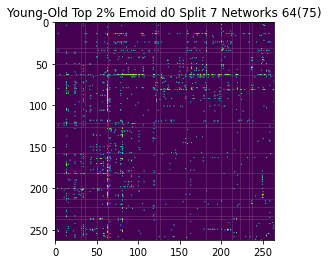

In [189]:
def rearrange(p,idcs):
    return p[:,idcs][idcs]

fig, ax = plt.subplots()

ax.imshow(rearrange(highlight(np.mean(stYoung, axis=0)-np.mean(stOld, axis=0), pct=0.02, top=True), revMap2))
for b in borders1:
    ax.plot([0,263],[b,b],color='pink',linewidth=0.5,alpha=0.3)
    ax.plot([b,b],[0,263],color='pink',linewidth=0.5,alpha=0.3)
ax.set_xlim(0,263)
ax.set_ylim(262,0)
ax.set_title('Young-Old Top 2% Emoid d0 Split 7 Networks 64(75)')
    
fig.show()
fig.savefig('../../Work/LatentSim/EmoidSplit7d074.png', format='png', bbox_inches='tight')

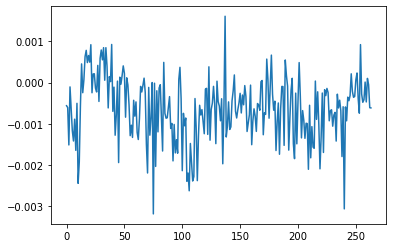

In [51]:
plt.plot((np.mean(stYoung, axis=0)-np.mean(stOld, axis=0))[74].T)
plt.show()

In [98]:
(np.mean(stYoung, axis=0)-np.mean(stOld, axis=0))[75,77]

0.004962707892730641

In [117]:
pYoung = gradGroup(nback_p, age, 0, 120)
pOld = gradGroup(nback_p, age, 20*12, 100*12)

print(pYoung.shape)
print(pOld.shape)

(47, 264, 264)
(35, 264, 264)


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


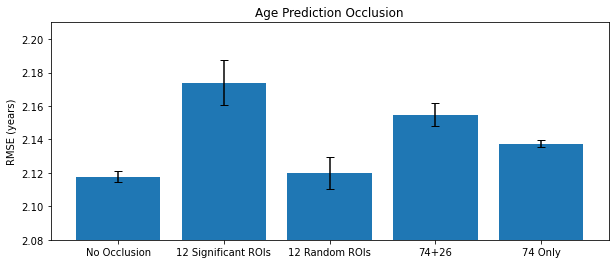

In [215]:

base = np.array([2.11495959, 2.114336936, 2.121793159, 2.120340157, 2.121212546,
                2.113928016])
target = np.array([2.159177987, 2.195234044, 2.174582672, 2.184550174, 2.15519913, 
                   2.16735212, 2.182058303])
random = np.array([2.12082723, 2.104936107, 2.119658629, 2.11539259, 2.129641485, 
                   2.123271751, 2.135961103, 2.110342566])
mini2 = np.array([2.148108244, 2.161557738])
mini1 = np.array([2.136369244, 2.135416079, 2.14074839])

mu = [np.mean(x) for x in [base, target, random, mini2, mini1]]
sigma = [np.std(x) for x in [base, target, random, mini2, mini1]]

fig, ax = plt.subplots(figsize=(10,4))

ax.bar(('No Occlusion', '12 Significant ROIs', '12 Random ROIs', '74+26', '74 Only'), mu, capsize=4, yerr=sigma)
ax.set_ylim([2.08,2.21])
ax.set_title('Age Prediction Occlusion')
ax.set_ylabel('RMSE (years)')

fig.show()
fig.savefig('../../Work/LatentSim/Occlusion.png', format='png', bbox_inches='tight')

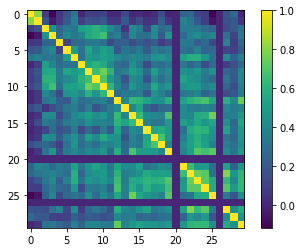

In [45]:
import matplotlib.pyplot as plt

plt.imshow(nback_p[2,:30,:30])
plt.colorbar()
plt.show()